### Notebook setup

#### Import shunpiker pre-set packages and modules
 
For an introduction to python packages and modules, see https://realpython.com/python-modules-packages/#python-packages.    

In [1]:
# import shunpiker pre-set packages and modules
%run shunpiker_modules.py

scanpy==1.8.2 anndata==0.7.6 umap==0.5.2 numpy==1.20.3 scipy==1.7.1 pandas==1.3.4 scikit-learn==1.0.1 statsmodels==0.13.0 python-igraph==0.9.8 pynndescent==0.5.5
phenograph== 1.5.7


💡 **Hint:** Use the code below ONLY if you need to install extra packages

In [2]:
#import sys
#!{sys.executable} -m pip install scrublet

#### Set notebook parameters

[`%matplotlib inline`](https://ipython.readthedocs.io/en/stable/interactive/tutorial.html#magics-explained) sets output of plotting commands to be displayed directly below the code cell that produced it.


<a id='part_1'></a>

In [3]:
# display plot directly below code cell
%matplotlib inline

## Sample "clean-up"

### Read in scRNA-seq raw counts into a python object

❗ Choose between [cellranger](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/output/overview) and [SEQC](https://github.com/dpeerlab/seqc) data format for your input

Both data inputs will be converted into a scRNA-seq friendly python object called an AnnData object. The AnnData object is  is made up of several components. For a more detailed explanation, see https://anndata.readthedocs.io/en/latest/anndata.AnnData.html#anndata.AnnData. 

Once you execute either of the input commands below, you should be able to access:
- counts: `adata.X` + Run
- gene names: `adata.var` + Run
- cell index and other annotation: `adata.obs` + Run

#### Input SEQC data

🕹️  Provide the path to your raw data and the name of your sample

In [4]:
# type path to your SEQC data folder (replace example path with your path)
path_to_seqc_data = '../data/'

In [5]:
# type name of your file (replace example file name with your file name)
sample_name = '3000_Vd2_healthy_IGO_12381_48_dense.csv'

In [6]:
# convert your selected sample/samples into one anndata object  
adata = import_seqc_data(path_to_seqc_data, sample_name)
adata.X = np.array(pd.DataFrame(adata.X).fillna(0)) # fill NAs with 0s

In [7]:
# randomize the order of cells for plotting
np.random.seed(42) 
index_list = np.arange(adata.shape[0])
np.random.shuffle(index_list)
adata = adata[index_list]

❗Using the line below you can check the number of cells (x, ) and genes ( ,y) that you have in your sample. 

This is a good sanity check after every filtering step to make sure the filters have been applied properly.

### Calculate quality control metrics for your sample before preprocessing

To start, we will calculate some standard quality control (QC) metrics using the `calc_QC_metrics()` function that is defined within the `shunpiker_modules.py` file. The QC metrics calculated include total counts, number of genes, and ribosomal and mitochondrial fraction on a per cell basis.

In [8]:
# caclutate QC metrics for your sample
calc_QC_metrics(adata)

Trying to set attribute `.obs` of view, copying.


❗To check if the QC metrics are now available for your sample, you can run the command below and inspect the column names.

In [9]:
# show top 5 rows from sample metadata (stored in adata.obs)
adata.obs.head()

n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
cell_barcodes                                                               
125745344702876               1162                 7.058758        3309.0   
240628318497564               2087                 7.643962        6851.0   
230746913462707               1718                 7.449498        5934.0   
204292779825564               1230                 7.115582        3420.0   
227982982724459               1290                 7.163172        4020.0   

                 log1p_total_counts  pct_counts_in_top_50_genes  \
cell_barcodes                                                     
125745344702876            8.104704                   40.858265   
240628318497564            8.832295                   36.724566   
230746913462707            8.688622                   41.439164   
204292779825564            8.137689                   39.766082   
227982982724459            8.299286                   42.512438   

                 pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
cell_barcodes                                                               
125745344702876                    54.850408                    66.334240   
240628318497564                    49.277478                    59.640928   
230746913462707                    54.718571                    64.829794   
204292779825564                    53.304094                    64.239766   
227982982724459                    57.686567                    67.761194   

                 pct_counts_in_top_500_genes  original_total_counts  \
cell_barcodes                                                         
125745344702876                    79.993956                 3309.0   
240628318497564                    72.923661                 6851.0   
230746913462707                    77.384564                 5934.0   
204292779825564                    78.654971                 3420.0   
227982982724459                    80.348259                 4020.0   

                 log10_original_total_counts  mito_frac  RBP_frac  
cell_barcodes                                                      
125745344702876                     3.519697   0.057721  0.381989  
240628318497564                     3.835754   0.047876  0.299226  
230746913462707                     3.773348   0.012302  0.400067  
204292779825564                     3.534026   0.023099  0.337427  
227982982724459                     3.604226   0.039055  0.419901

### Data "clean-up": identification of doublet cells

We will use the scanpy implementation ([`scanpy.external.pp.scrublet`](https://scanpy.readthedocs.io/en/latest/generated/scanpy.external.pp.scrublet.html#scanpy-external-pp-scrublet)) of the [scrublet package](https://github.com/swolock/scrublet) to identify doublet cells. This command will use the default parameters of `scanpy.external.pp.scrublet`, however, if you are feeling brave or disagree with the predicted doublets you can use this [example notebook](https://github.com/swolock/scrublet/blob/master/examples/scrublet_basics.ipynb) to alter any of these parameters.

In [10]:
# run scanpy implementation of the scrublet package to identify doublet cells
sc.external.pp.scrublet(adata)

/home/kousaa/miniconda3/envs/AK011_py38/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.55
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 18.2%


### Data "clean-up": removal of not expressed genes

Genes with zero counts across all cells will not provide any biological insight, but rather delay some of the downstream processing steps, thus we choose to remove genes that are not expressed in any cells. You can make this step more stringend by asking genes to be expressed in at least N number of cells.

In [11]:
# remove genes that are not expressed in any cells (remove columns with all 0s)
sc.pp.filter_genes(adata, min_cells=1)

In [12]:
adata.shape

(10478, 17817)

### Data "clean-up": removal of rRNA

Ribosomal protein (RBP) RNA often constitutes between 20-50% of your counts. Variation in their expression can therefore highly affect the outcome of your visualization algorithms and differential gene expression analyses. Our experience is that expression levels of RBP RNA often cannot be reproduced or validated, and are moreover difficult to interpret. One can therefore decide to remove these genes from the data altogether.

In [13]:
adata = remove_RBs(adata)

### Data "clean-up": data normalization

RNA counts generally vary linearly with library size: RNA molecules have a steady concentration rather than a steady absolute number (Additional variation suggests biological variation in gene expression among your cells). Therefore, it is usually appropriate to normalize each cell to the same total library size, thereby converting RNA counts to a relative rather than absolute count. Below a random gene is plotted against library size to show that expression, at least if not variable between cell types in your sample, changes according to library size. We take a gene with a minimum gene expression of 1, because trends in genes with low mean expression are occluded by noise. Run the cell below a few times to inspect the general trend between gene expression and library size. Note that scRNA-seq data is highly noisy, and the correlation will therefore be noisy as well in genes with lower expression.

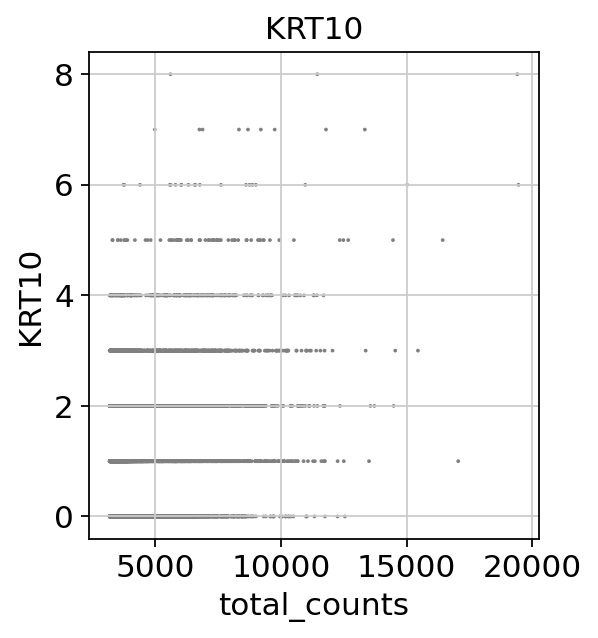

In [14]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
observe_library_size_effect(adata)

An alternative method to normalize data is using SCRAN that applies a similar principle to common normalization methods in bulk RNA data.

Here we will normalize to a total library size of 10,000. Scanpy will update our count matrix (adata.X) automatically with the normalized counts.

In [15]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=10**4)

Trying to set attribute `.obs` of view, copying.


### Data "clean-up": log-transformation

Log transformation makes changes in expression relative rather than absolute (e.g. it looks at doubling (when using log2) of expression rather than increase of n counts in expression). It makes the differences between highly and lowly expressed genes smaller, and limits the effects of highly expressed genes on your data analysis. It is often considered a default part of preprocessing, but can occasionally be better left out. The desired effect of a log-transformation is that it brings out biological differences between your cell populations better. <br>
Scanpy's log transformation function takes the natural logarithm of each (count + 1), and updates your count matrix (adata.X): 

In [16]:
sc.pp.log1p(adata)

### Let's have a look at our data

UMAP embedding gives us a two-dimensional representation of our data, based on the similarities/differences among the cells in a higher-dimensional space. Each type of mapping has its own strenghts and weaknesses, thus it can be useful to take a look at different mappings. Using a selection of principal components before UMAP will not only shorten computation time, but also reduces noise.

In [17]:
rng = np.random.RandomState(42)
adata = sc.tl.pca(adata, n_comps=200, copy = True, svd_solver='arpack', random_state=rng)

We can visualize the percentage of variance explained by each PC. Based on this figure, we will select a number of principal components to use in the rest of our analysis. 

<function matplotlib.pyplot.show(close=None, block=None)>

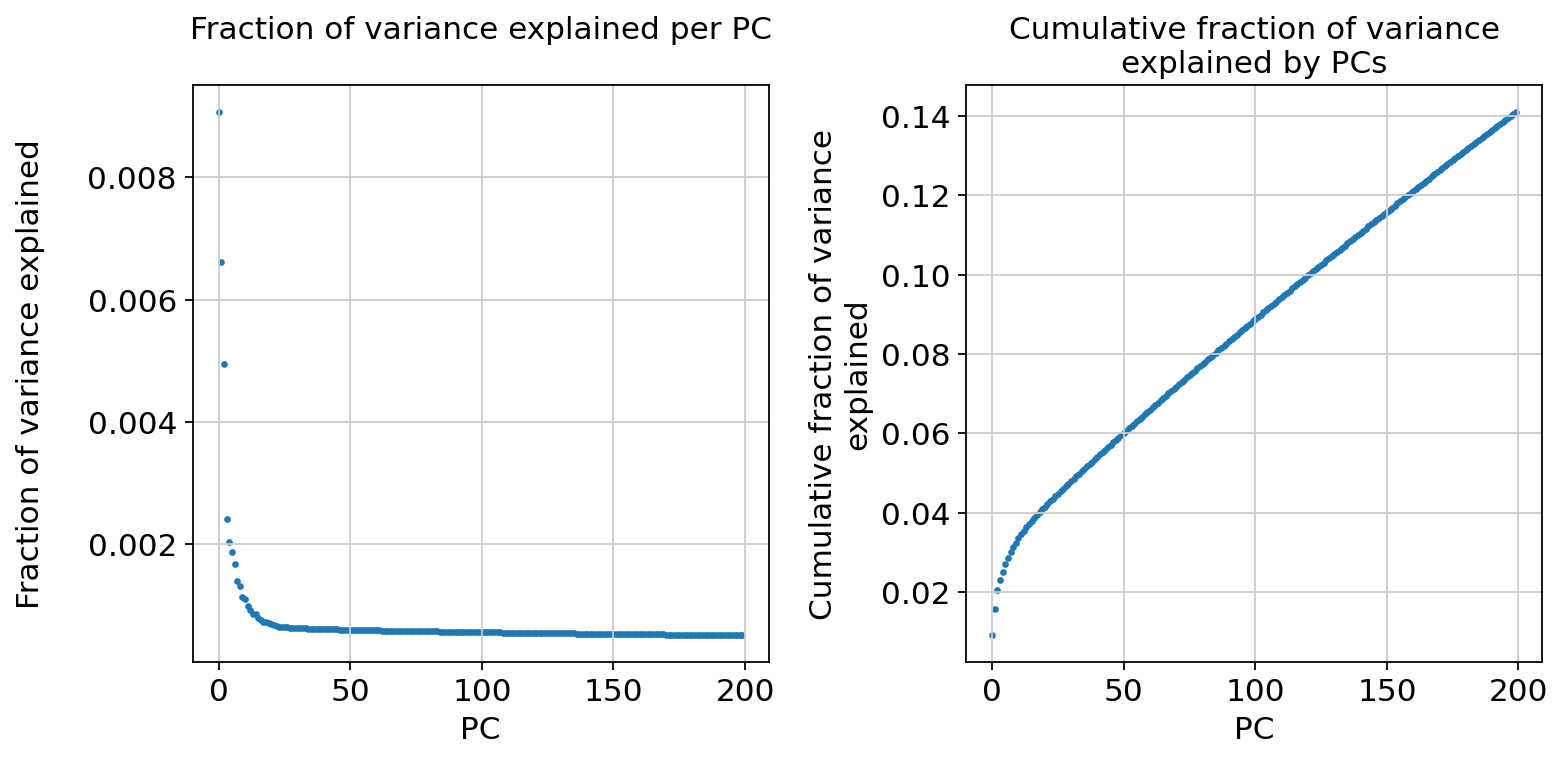

In [18]:
observe_variance(adata)

❗ We want to include all the principal components before the 'knee point' (the point where the fitted curve would change slope the most), because these likely represent important sources of variance in our data. To try to avoid eliminating any relevant but small sources of variance, we will choose a number of PCs slightly to the right of the knee point. 

🕹️  Replace the number below with your selection and run PCA again.

In [27]:
rng = np.random.RandomState(42)
sc.tl.pca(adata, n_comps=30, svd_solver='arpack', random_state=rng)

We will now run UMAP. When dealing with a very large dataset, it might be useful to use a perplexity higher than the default (`n_neighbors=15`). The command below will automatically use our PCA as a basis for calculating the embedding.

In [28]:
sc.pp.neighbors(adata, n_neighbors=15)

In [29]:
sc.tl.umap(adata)

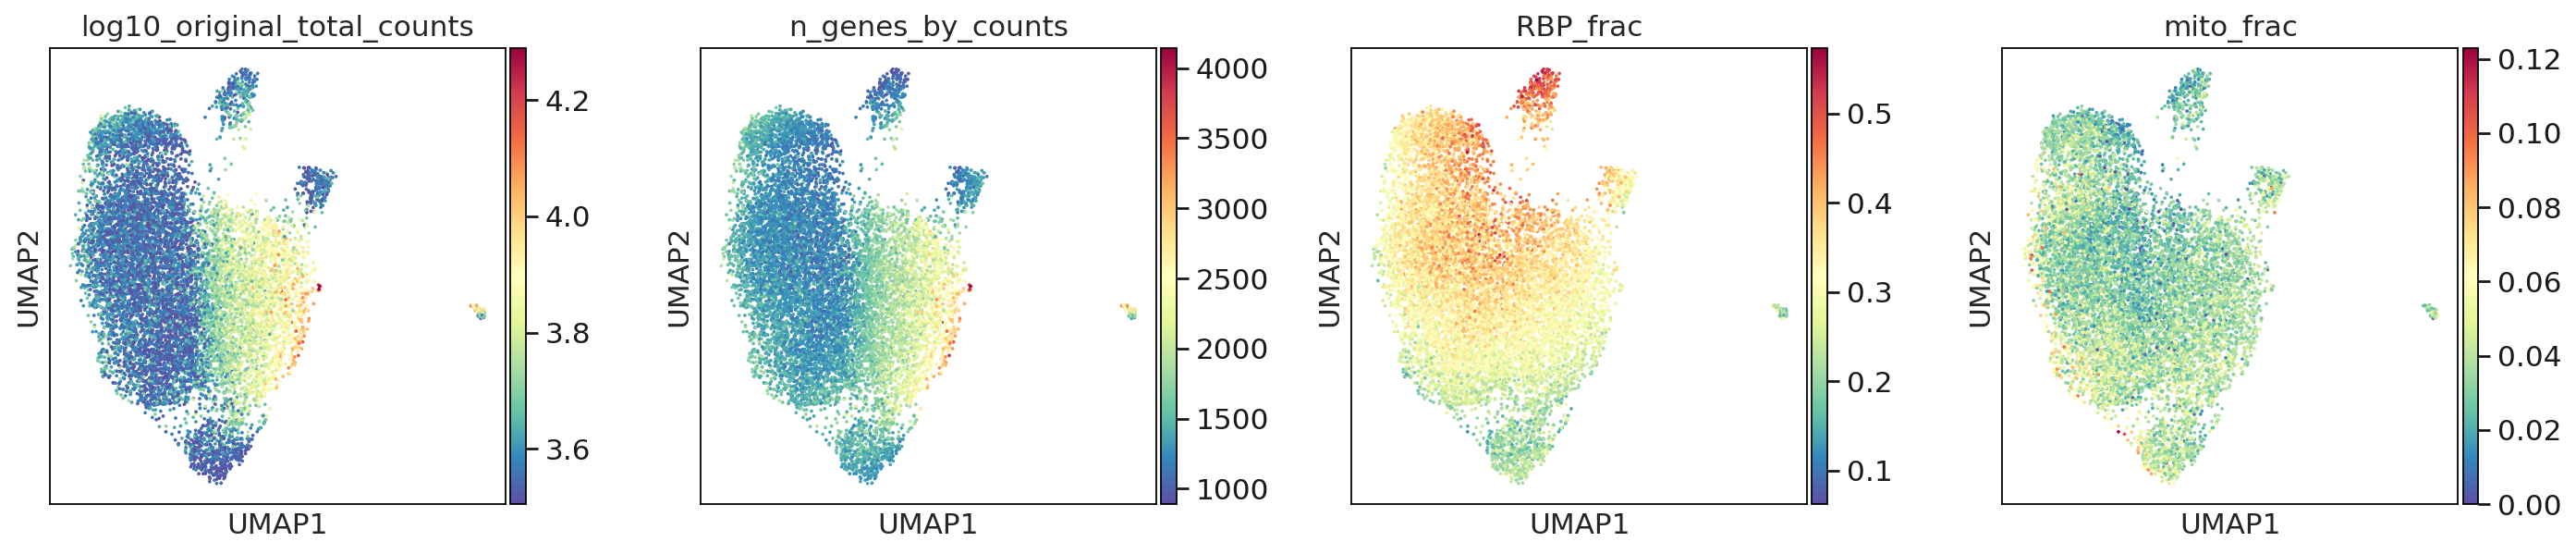

In [30]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
# plot major canonical markers as a sanity check
sc.pl.umap(
    adata, 
    color=['log10_original_total_counts', 'n_genes_by_counts','RBP_frac', 'mito_frac'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

🕹️ Inspect canonical markers of your choice

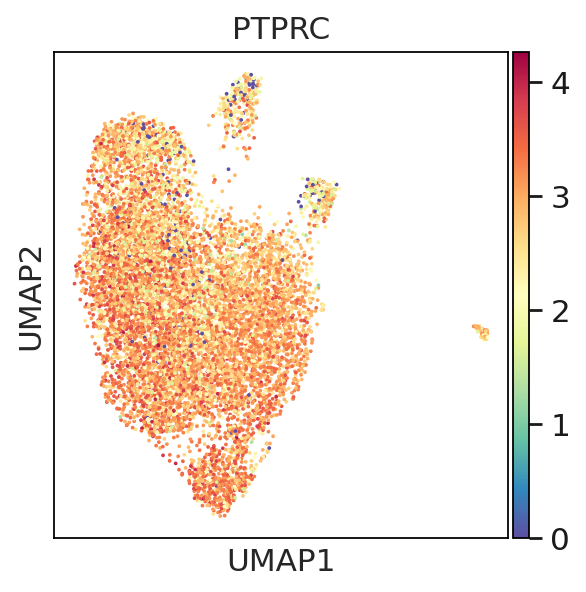

In [31]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
# plot major canonical markers as a sanity check
sc.pl.umap(
    adata, 
    color=['PTPRC'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=5,
    wspace = 0.3,
    sort_order = False
)

❗ **Does your data look well distinguished?** If yes, move ahead. If no, maybe try to increase the number of principal components you used, and rerun the last bits of code.

### Run unsupervised clustering analysis using PhenoGraph

Next, we will filter out cells that we think are either dying cells or empty droplets. Both are characterized by low library size, dying cells additionally have relatively high percentages of mitochondrial RNA. Rather than using cutoffs, we remove cells by cluster. This prevents us from taking out cells that belong to a biologically relevant cluster, despite having e.g. low library size or high mitochrondrial RNA. It furthermore ensures that we take out all cells with a phenotype similar to what we think are cells that should be taken out, even if they happen not to exceed a possible cutoff we would have otherwise chosen. We can furthermore remove clusters that we are not interested in, such as doublets and contaminants.

For clustering, we use [PhenoGraph](https://www.sciencedirect.com/science/article/pii/S0092867415006376). This is a highly robust graph-based clustering algorithm that was designed for single cell data. Your choice of k (number of nearest neighbors to use for graph construction) can affect the number of clusters and their size.

❗ How to select a number for neighbour cells (k) for fairly robust clustering.

Calculate clustering characteristics for a range of ks (5 to 155), by a step of 5.

Inspect the following clustering metrics:
- Minimum number of k for a connected graph.
- Changes in Q-modularity score (see PhenoGraph paper) for different ks. The Q-modularity usually drops quickly in the beginning (due to swiftly increasing connectedness when increasing a low k), and only slightly decreases after a certain point. However, in the case of homogeneous data with little structure, you might see a constant rapid decay in Q score. The plot below is not needed for a good choice of k, but is informative about the modularity of your data.
- Similarity/difference in cluster assignments between the different ks. We will use the Rand index to this end. The Rand index algorithm compares to clusterings by testing for every pair of cells, whether or not they were both clustered together or separately in both clusterings. E.g. if two cells were not in the same cluster in clustering 1, but were clustered together in clustering 2, this will decrease the Rand score. Alternatively, if they were in separate clusters in both cases, or in the same cluster in both cases, this will increase the score. The Rand index ranges from 0 to 1, with 1 indicating identical cluster assignments. We will calculate the Rand indices for all pairs of k and visualize the Rand indices using a heatmap, with our chosen range of k in the rows and columns, and the color indicating similarity in cluster assignments (red=high similarity, blue=low similarity). We can use the heatmap to find a region of ks where the clustering is fairly similar between runs (e.g. an index around 0.8 or higher). Within that 'robust region', we should choose a low k to retain as much resolution as possible.

⏳ This step might take a while so be patient

In [32]:
# calculate clustering characteristics for a range of ks (5 to 155), by a step of 5.
ks = np.arange(5,155,5)
cluster_chars = [calc_clustering_characteristics(k, adata.obsm['X_pca']) for k in ks];

Finding 5 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.4245657920837402 seconds
Jaccard graph constructed in 12.42109990119934 seconds
Wrote graph to binary file in 0.013848543167114258 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.92618
Louvain completed 21 runs in 4.193663835525513 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 24.465856552124023 seconds
Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.3639163970947266 seconds
Jaccard graph constructed in 6.7256011962890625 seconds
Wrote graph to binary file in 0.10522103309631348 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.799846
After 4 runs, maximum modularity is Q = 0.802928
Louvain completed 24 runs in 5.715863943099976 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 20.39023518562317 seconds
Fi

After 1 runs, maximum modularity is Q = 0.707109
After 3 runs, maximum modularity is Q = 0.70834
After 4 runs, maximum modularity is Q = 0.710531
After 5 runs, maximum modularity is Q = 0.712726
Louvain completed 25 runs in 15.5965735912323 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 57.832334995269775 seconds
Finding 85 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.3957459926605225 seconds
Jaccard graph constructed in 29.785125255584717 seconds
Wrote graph to binary file in 0.9307718276977539 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.704926
After 2 runs, maximum modularity is Q = 0.709897
After 3 runs, maximum modularity is Q = 0.711711
Louvain completed 23 runs in 19.82578992843628 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 58.68121004104614 seconds
Finding 90 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors 

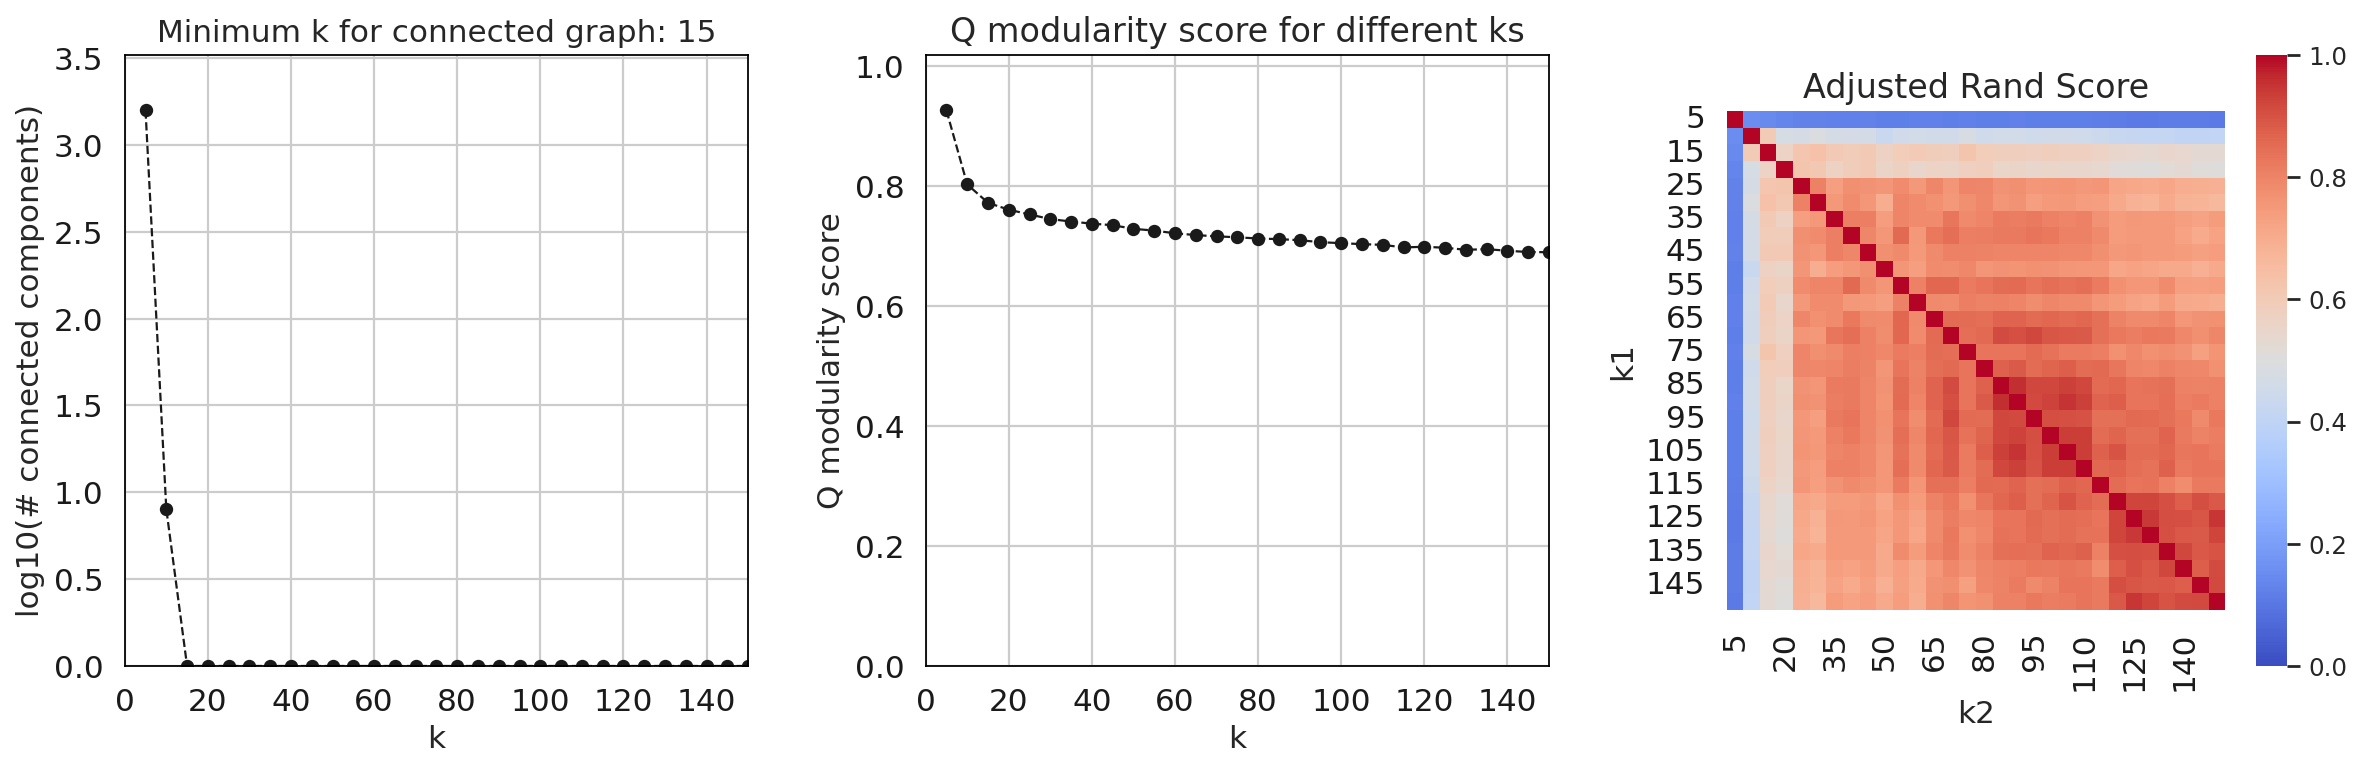

In [33]:
# plot clustering metrics
Rand_index_df = inspect_clustering_chars(ks, cluster_chars)

In [35]:
# print table with rand scores for the different ks
Rand_index_df.iloc[1:15,1:15]

k2        10        15        20        25        30        35        40  \
k1                                                                         
10  1.000000  0.598160  0.475692  0.468929  0.488519  0.469891  0.465897   
15  0.598160  1.000000  0.564473  0.620937  0.633670  0.607125  0.597545   
20  0.475692  0.564473  1.000000  0.621530  0.611812  0.570339  0.587408   
25  0.468929  0.620937  0.621530  1.000000  0.805492  0.736768  0.773987   
30  0.488519  0.633670  0.611812  0.805492  1.000000  0.753716  0.783863   
35  0.469891  0.607125  0.570339  0.736768  0.753716  1.000000  0.811963   
40  0.465897  0.597545  0.587408  0.773987  0.783863  0.811963  1.000000   
45  0.463533  0.607746  0.606773  0.768166  0.756774  0.810958  0.794868   
50  0.429769  0.570815  0.556428  0.758504  0.698737  0.738858  0.755953   
55  0.456935  0.591577  0.574726  0.781340  0.797410  0.799863  0.856204   
60  0.459558  0.603312  0.545796  0.753431  0.784283  0.783047  0.751549   
65  0.454219  0.588648  0.564098  0.796358  0.772466  0.781916  0.825445   
70  0.457024  0.585407  0.557158  0.761442  0.752554  0.828950  0.844411   
75  0.477653  0.623912  0.580132  0.798172  0.775083  0.785551  0.810372   

k2        45        50        55        60        65        70        75  
k1                                                                        
10  0.463533  0.429769  0.456935  0.459558  0.454219  0.457024  0.477653  
15  0.607746  0.570815  0.591577  0.603312  0.588648  0.585407  0.623912  
20  0.606773  0.556428  0.574726  0.545796  0.564098  0.557158  0.580132  
25  0.768166  0.758504  0.781340  0.753431  0.796358  0.761442  0.798172  
30  0.756774  0.698737  0.797410  0.784283  0.772466  0.752554  0.775083  
35  0.810958  0.738858  0.799863  0.783047  0.781916  0.828950  0.785551  
40  0.794868  0.755953  0.856204  0.751549  0.825445  0.844411  0.810372  
45  1.000000  0.777163  0.785228  0.748849  0.787026  0.806867  0.806642  
50  0.777163  1.000000  0.759660  0.738036  0.785081  0.779121  0.791381  
55  0.785228  0.759660  1.000000  0.806669  0.862585  0.861737  0.819319  
60  0.748849  0.738036  0.806669  1.000000  0.786993  0.783411  0.811544  
65  0.787026  0.785081  0.862585  0.786993  1.000000  0.855389  0.847832  
70  0.806867  0.779121  0.861737  0.783411  0.855389  1.000000  0.844859  
75  0.806642  0.791381  0.819319  0.811544  0.847832  0.844859  1.000000

🕹️ Using the heatmap and table above choose a value for k. 

As rule of thumb, choose a connected graph k with an adjusted Rand score >=0.8 for 4 consecutive steps. 

In [36]:
# run unsupervised clustering analysis with PhenoGraph
k=55 # add your selected k value here
communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata.obsm['X_pca']),k=k)
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 55 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 4.962625503540039 seconds
Jaccard graph constructed in 19.436025619506836 seconds
Wrote graph to binary file in 0.669353723526001 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.724336
After 8 runs, maximum modularity is Q = 0.726686
Louvain completed 28 runs in 23.147634744644165 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 57.12903308868408 seconds


We can visualize the clustering to see which clusters match with the cells that we would like to filter out. Inspect the list of QC metrics and canonical markers to make your choice.

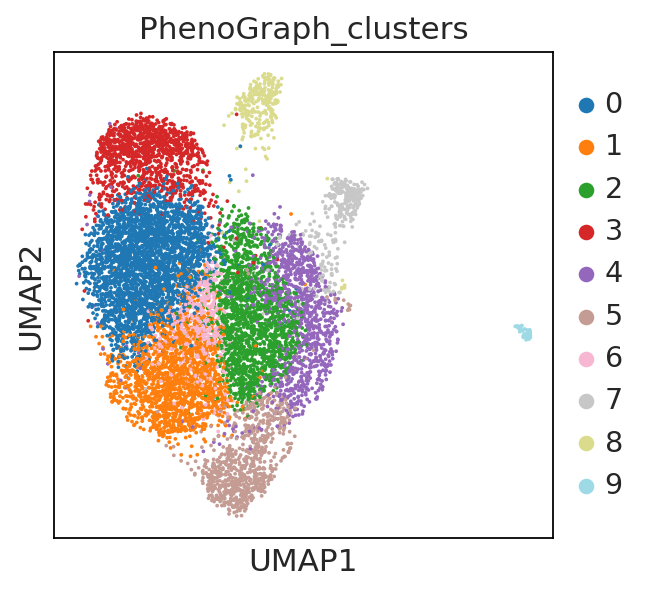

In [37]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.5,
    sort_order = False
)

### Filtering out cells: by cluster

Now inspect tha QC metrics for each of the clusters and choose to remove any clusters that may have a combination of bad quality metrics.

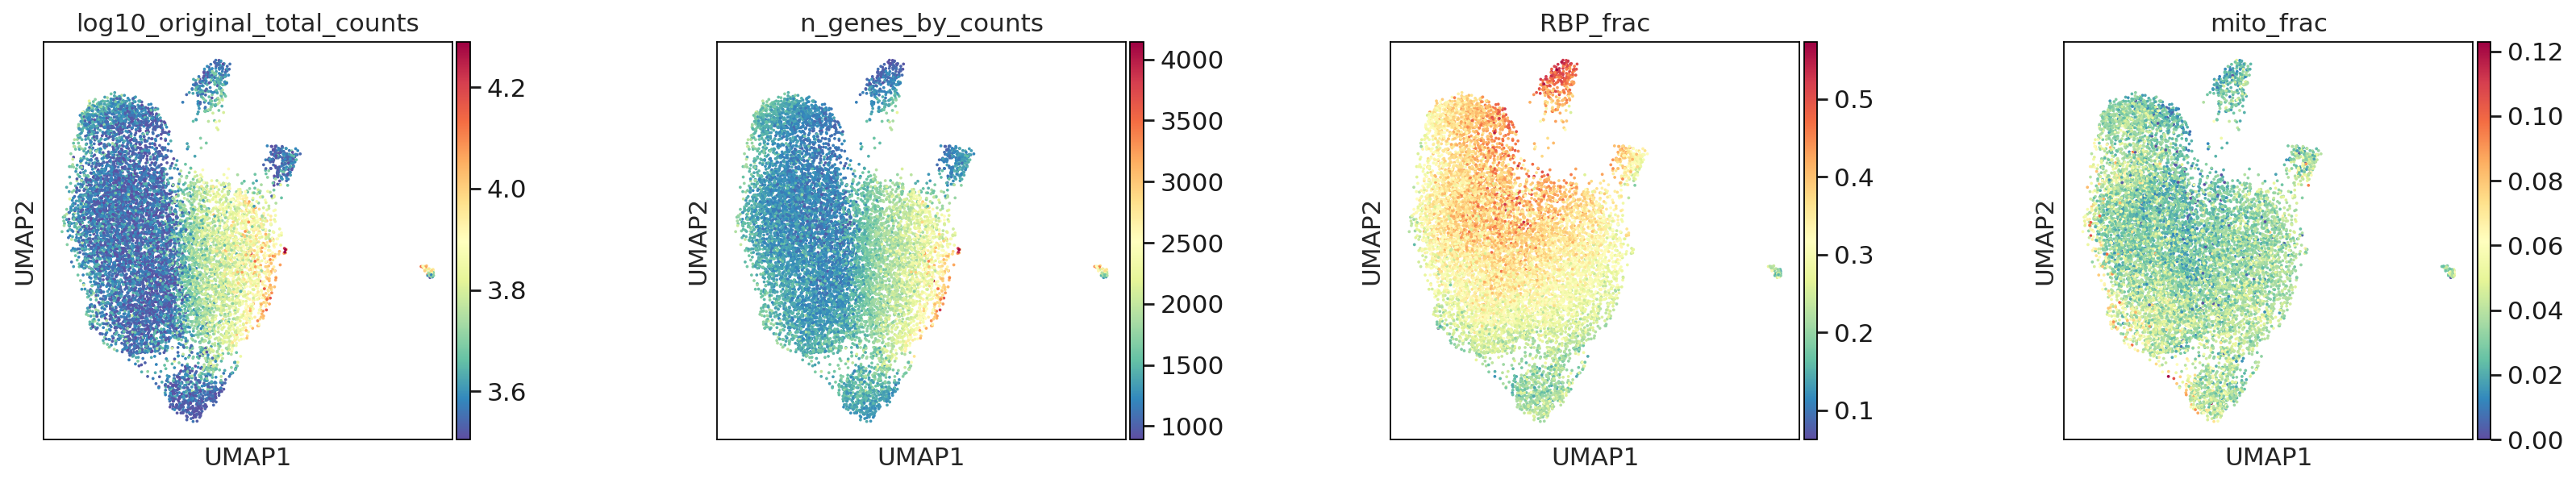

In [38]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
sc.pl.umap(
    adata, 
    color=['log10_original_total_counts', 'n_genes_by_counts','RBP_frac', 'mito_frac'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.5,
    sort_order = False
)

In [40]:
adata.shape

(10478, 17646)

### Filtering out cells: doublets and contaminants

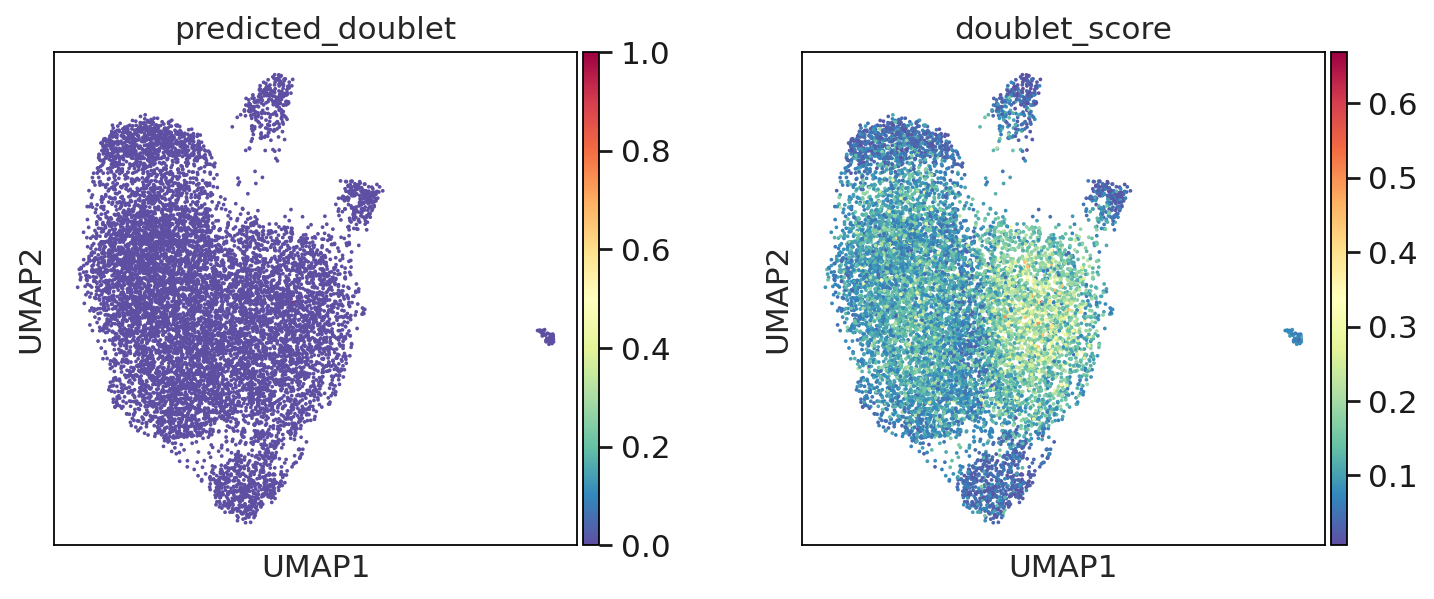

In [43]:
sc.pl.umap(
    adata, 
    color=['predicted_doublet', 'doublet_score'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

This would be also a good spot to remove the doublets you have identified above or any other cell population that does not match your experimental strategy

In [44]:
adata = adata[adata.obs['predicted_doublet'] == False]

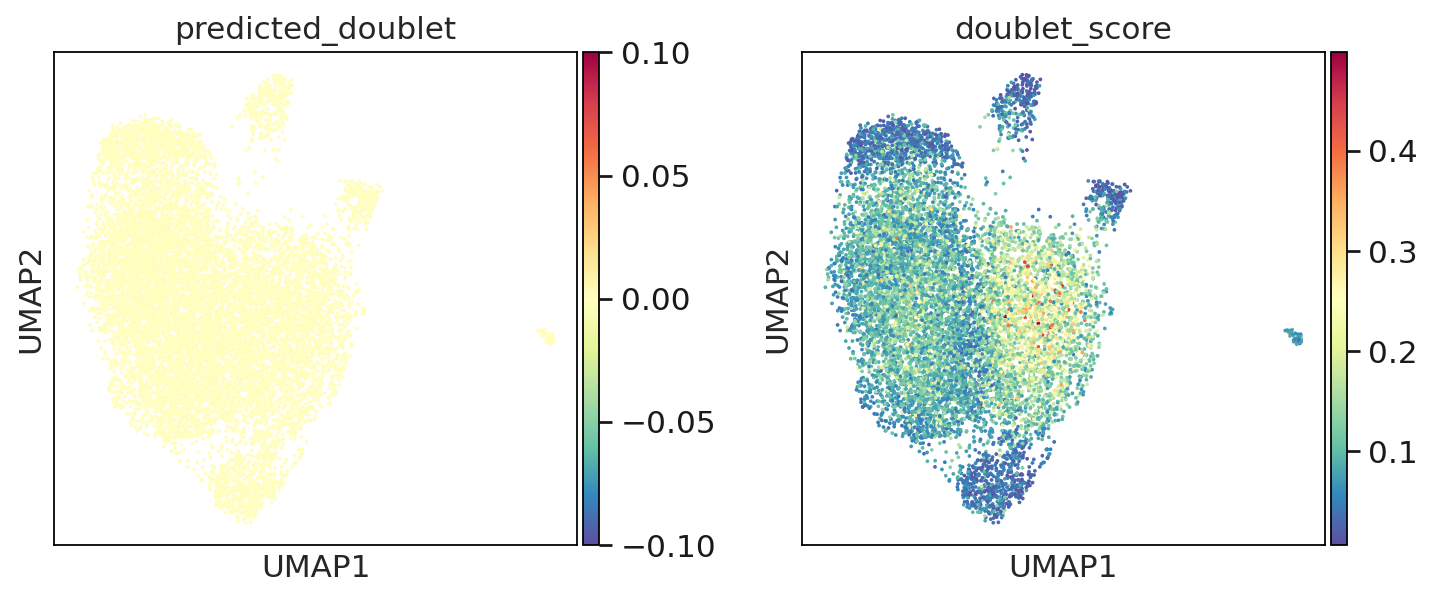

In [45]:
sc.pl.umap(
    adata, 
    color=['predicted_doublet', 'doublet_score'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

Let's now inspect if the right number of doublet cells has been removed from the dataset.

In [46]:
adata.shape

(10477, 17646)

### Reanalyze data after removal of cells

Once we have removed all unwanted cells, we need to reanalyze our data in a similar way to steps 4 and 5. 

In [47]:
rng = np.random.RandomState(42)
adata = sc.tl.pca(adata, n_comps=200, copy = True, svd_solver='arpack', random_state=rng)

<function matplotlib.pyplot.show(close=None, block=None)>

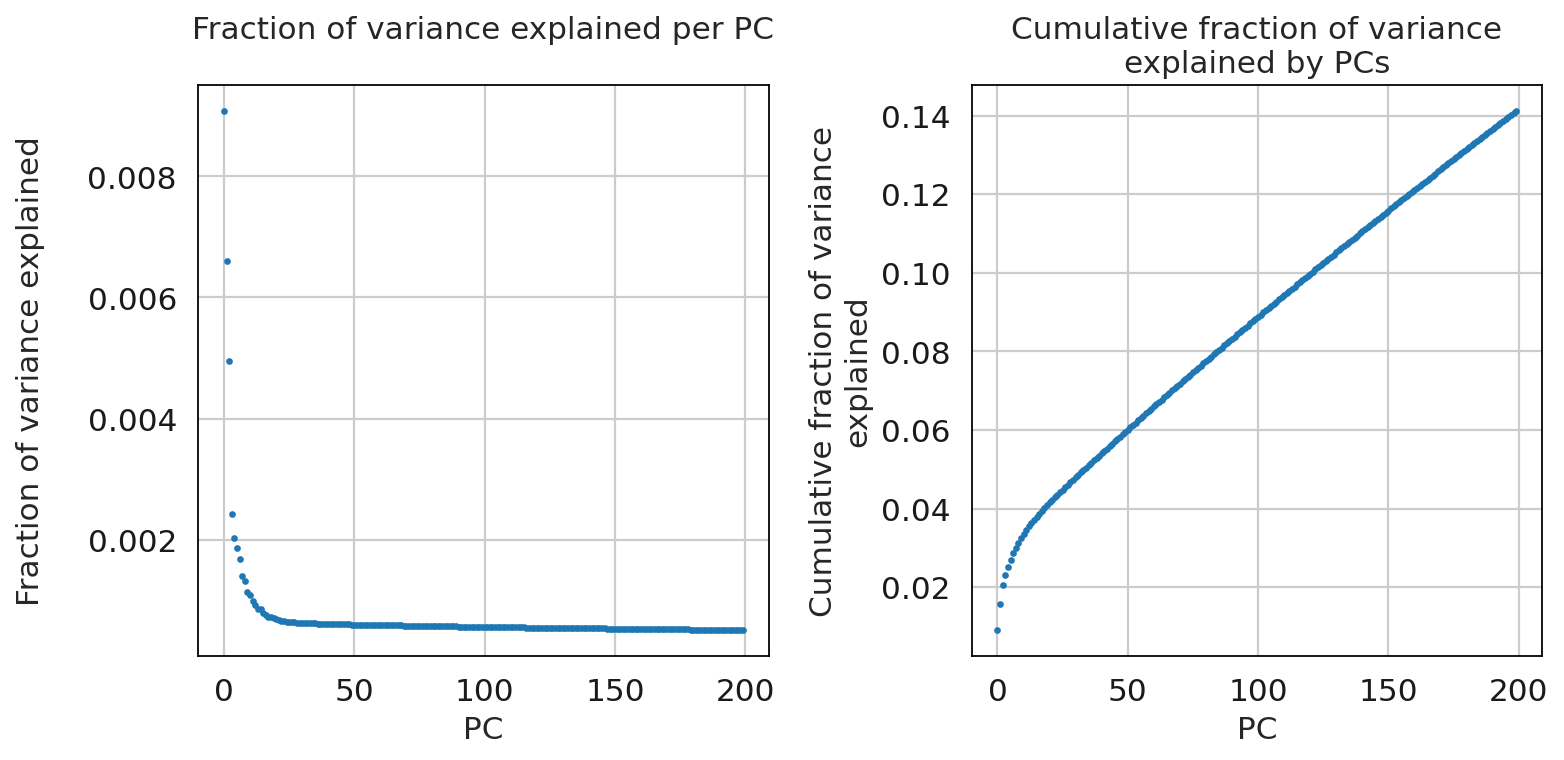

In [48]:
observe_variance(adata)

🕹️ Remember to choose a different number of principal components based on the re-analysis

In [49]:
rng = np.random.RandomState(42)
sc.tl.pca(adata, n_comps=30, svd_solver='arpack', random_state=rng)

In [50]:
sc.pp.neighbors(adata, n_neighbors=15)

In [51]:
sc.tl.umap(adata)

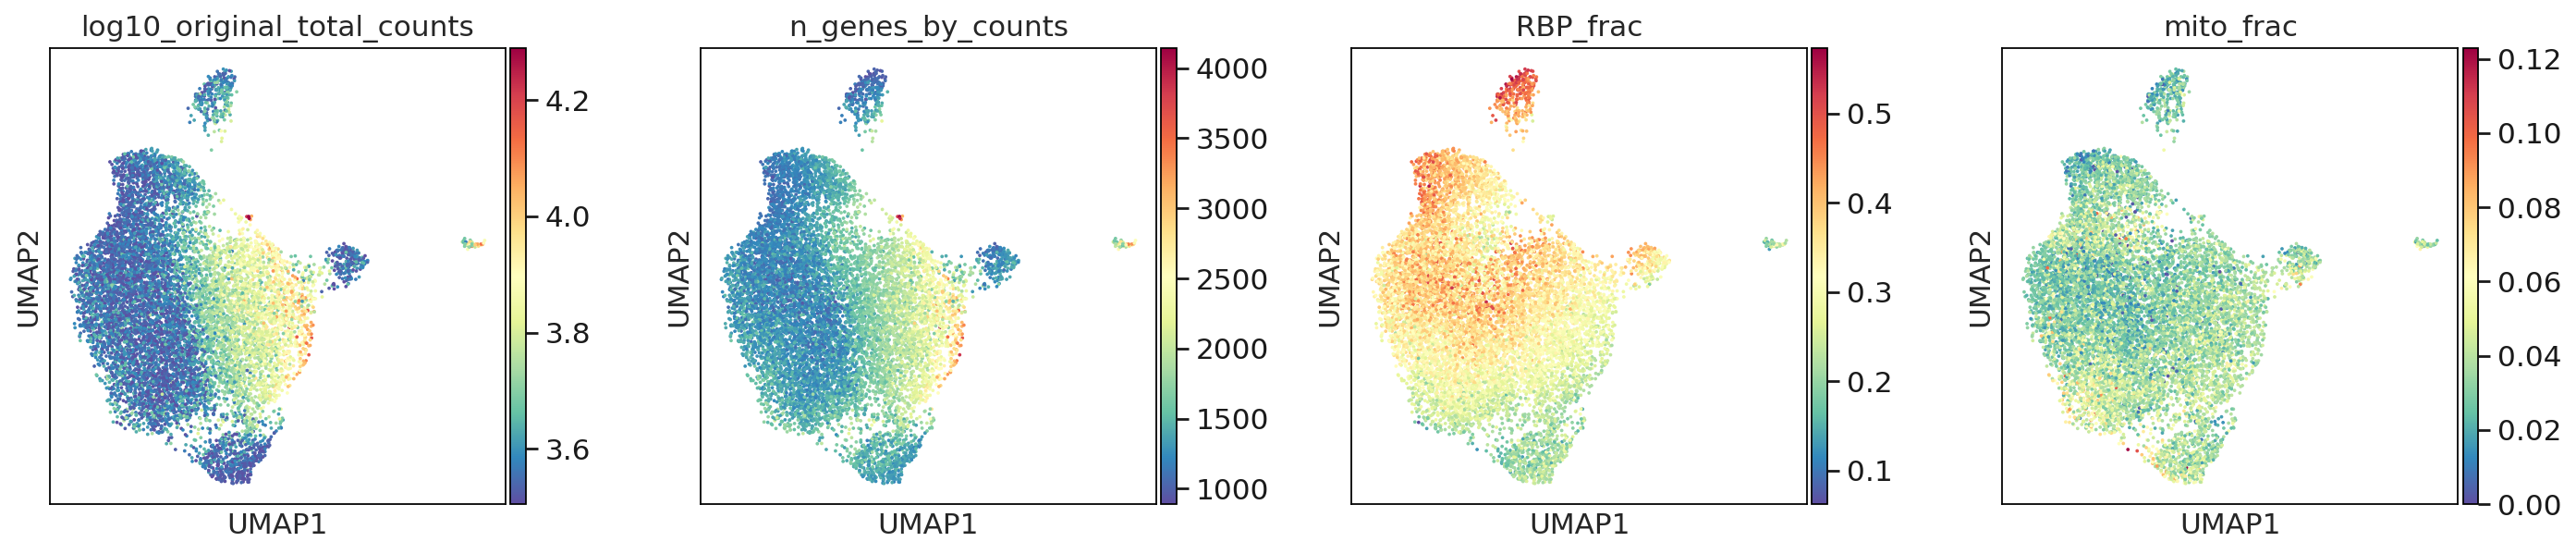

In [52]:
sc.pl.umap(
    adata, 
    color=['log10_original_total_counts', 'n_genes_by_counts','RBP_frac', 'mito_frac'], 
    palette='tab20', 
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

You are done! Just save you file and save the index of you cells. You can now come back to this dataset at anytime.

PS. For more visualization options check the scanpy tutorials.

In [54]:
path_to_h5ad = '/home/kousaa/scRNAseq-analysis/[AK011] Hana_unconvencional-Tcells/notebooks/files/Vd2_healthy.h5ad'

In [55]:
adata.write(path_to_h5ad)

In [ ]:
adata = sc.read_h5ad(path_to_h5ad)

In [56]:
# save index of your good quality cells for future use
QCpassed_cells = adata.obs.index
QCpassed_cellsDF = pd.DataFrame(QCpassed_cells)
QCpassed_cellsDF.to_pickle('files/Vd2_healthy_QCpassed.pkl')

In [57]:
QCpassed_cells.shape

(10477,)

In [58]:
%load_ext watermark

In [59]:
%watermark

Last updated: 2021-11-10T10:27:55.501501-05:00

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.29.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 3.10.0-957.12.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 72
Architecture: 64bit

